In [3]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# import joblib
# sys.modules['sklearn.externals.joblib'] = joblib
# from sklearn.preprocessing import Imputer
# sys.modules['sklearn.preprocessing.Imputer'] = Imputer
from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [4]:
use_gpu = True

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

LISA PSD function 

In [5]:
def power_spectral_density_RCLfit(freq):
    r"""
    Return the effective power spectral density (PSD) of the detector noise
    at a given frequency, according to the analytical fit by Robson, Cornish
    and Liu, :arxiv:`1803.01944`

    INPUT:

    - ``freq`` -- frequency `f` (in `\mathrm{Hz}`)

    OUTPUT:

    - effective power spectral density `S(f)` (in `\mathrm{Hz}^{-1}`)

    EXAMPLES::

        sage: from kerrgeodesic_gw import lisa_detector
        sage: Sn = lisa_detector.power_spectral_density_RCLfit
        sage: Sn(1.e-1)  # tol 1.0e-13
        2.12858262120861e-39
        sage: Sn(1.e-2)  # tol 1.0e-13
        1.44307343517977e-40
        sage: Sn(1.e-3)  # tol 1.0e-13
        1.63410027259543e-38

    """
    p_oms = 2.25e-22 * (1 + (2.e-3/freq)**4)
    p_acc = 9.e-30 * (1 +(4.e-4/freq)**2) * (1 + (freq/8.e-3)**4)
    L = 2.5e9
    f_star = 1.909e-2
    p_n = (p_oms + 2*(1 + np.cos(freq/f_star)**2)*p_acc/(2*(np.pi)*freq)**4)/L**2
    return 10./3.*p_n*(1 + 0.6*(freq/f_star)**2)

In This section I will explore the Black hole perturbation tool kit. Key idea is to reproduce
the results of [3] where Sage Math has been used instade of BHP toolkit. Since we are
interested in the $Srg A^∗$,I will use the mass of the black hole to be $M = 4.15±0.27×106M_⊙$
form [4]. Lets Consider an object orbiting the Black hole with mass $\mu = 5\times 10^{-2}$.


In [6]:
# This block of code is setting up the initial conditions for generating a gravitational waveform.


M = 4.15e6 # mass of the black hole in solar masses
mu = 5e-2 # mass of the compact object in solar masses
dist1 = 0.000008277 # distance to the source in gigaparsecs
e0 = 0.0 # initial eccentricity
theta = np.pi / 2  # polar viewing angle
phi = 0  # azimuthal viewing angle
dt = 15 # time step in seconds
p0 = 6.15 # initial semilatus rectum in this case our orbit is circular. thus p =r = 6.15. 
t0 = 0.0 # initial time
T = T=2000/(365.25*24*3600) # total time in years to generate the waveform
wave = few(M, mu, p0, e0, theta, phi, dist=dist1, dt=dt, T=T) # generate the waveform

wave2 = few(M, mu, p0, e0, theta, phi, dist=dist1, dt=dt, T=2) # generate the waveform
wave3 = few(M, mu, p0, e0, theta, phi, dist=dist1, dt=dt, T=3) # generate the waveform

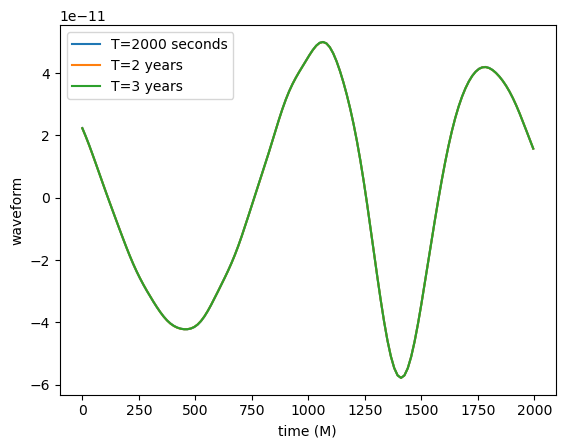

In [7]:
# this block of code is generating the waveform and plotting it.
t= np.arange(len(wave)) * dt  # time array
# make a constant with p0/mu and multiply it with the wave.real 
# to get the waveform in the right units
waveformReal = (M*p0)/mu * wave.real
waveformReal2 = (M*p0)/mu * wave2.real
waveformReal3 = (M*p0)/mu * wave3.real
# plot waveformreal vs t , waveformreal2 vs t, waveformreal3 vs t
plt.figure()
plt.plot(t,waveformReal[:134].get(), label='T=2000 seconds')
plt.plot(t, waveformReal2[:134].get(), label='T=2 years')
plt.plot(t, waveformReal3[:134].get(), label='T=3 years')
plt.xlabel('time (M)')
plt.ylabel('waveform')
plt.legend()
plt.show()


The plot above show that depending on the integration time the waveform does not changes. 

In [8]:

theta = np.pi/2  # polar viewing angle
phi =0 # azimuthal viewing angle
dt = 10
dist1 = 0.000008277
# wave = few(M, mu, p0, e0, theta, phi, dt=dt, T=2000/(365.25*24*3600)  )

wave1 = few(M, mu, p0, e0, theta, phi, dist=dist1, dt=dt, T=2000/(365.25*24*3600))  

In [9]:
# this data has been created by a sage file. a two column file named time_and_A.txt is created with the time and amplitude values. read the file and store the values in a list
time = []
amplitude = []
with open('time_and_h.txt', 'r') as file:
    for line in file:
        t, a = line.split()
        time.append(float(t))
        amplitude.append(float(a))

Time= np.array(time)
Amplitude= np.array(amplitude)



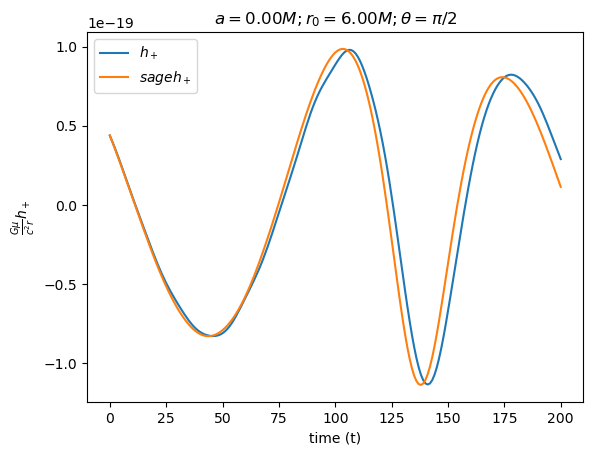

In [10]:
t = np.arange(len(wave1))

plt.plot(wave1.real.get(), label=r'$h_+$')
plt.plot(Amplitude, label=r'$sage h_+$')
# plt.plot(wave.imag[:220],label=r'$h_x$')
plt.xlabel(r'time (t)')
plt.ylabel(r'$\frac{G \mu}{c^2 r} h_+ $')
# title a = 0:00M; r0 = 6:000M; theta = pi ¼
plt.title(r'$a = 0.00M; r_0 = 6.00M; \theta = \pi/2$')
plt.legend()
plt.show()


In [11]:
wave2 = few(M, mu, p0, e0, np.pi/4, phi, dist=dist1, dt=dt, T=0.1)
t = np.arange(len(wave2))*dt

In [12]:
# this data has been created by a sage file. a two column file named time_and_A.txt is created with the time and amplitude values. read the file and store the values in a list
time = []
amplitude = []
with open('time_and_h_4.txt', 'r') as file:
    for line in file:
        t, a = line.split()
        time.append(float(t))
        amplitude.append(float(a))

Time4= np.array(time)
Amplitude4= np.array(amplitude)

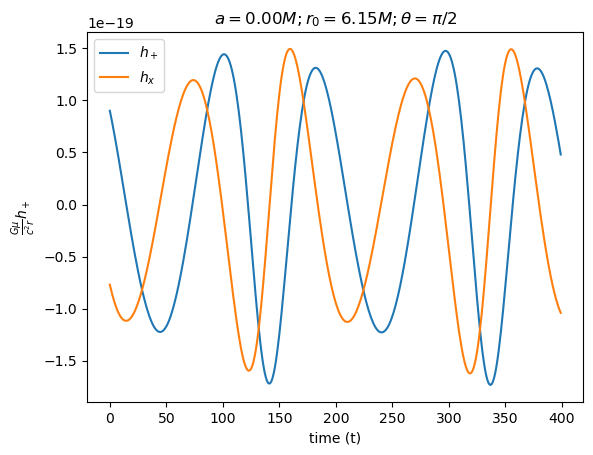

In [13]:
t = np.arange(len(wave1))

plt.plot(wave2.real[:400].get(), label=r'$h_+$')
plt.plot(wave2.imag[:400].get(), label=r'$ h_x$')
# plt.plot(Amplitude, label=r'$sage h_+$')
# plt.plot(wave.imag[:220],label=r'$h_x$')
plt.xlabel(r'time (t)')
plt.ylabel(r'$\frac{G \mu}{c^2 r} h_+ $')
# title a = 0:00M; r0 = 6:000M; theta = pi ¼
plt.title(r'$a = 0.00M; r_0 = 6.15M; \theta = \pi/2$')
plt.legend()
plt.show()


Results here matches with the paper.        Now we focus into  the S/R of the waveform and its detectibility by LISA. 
We will take $a=0, \theta = \pi/2 $ and $ 9 M< r_0 < 16.15M$ and vary the eccentricity of the orbit. The observation day would be one day or 1/365 year.    

But before that I will bring the PSD from sage. 


In [14]:
# read psd.txt and strote two colum in two different arrarys
freq = []
psd = []
with open('psd.txt', 'r') as file:
    for line in file:
        f, p = line.split()
        freq.append(float(f))
        psd.append(float(p))
sumpsd = np.sum(psd)


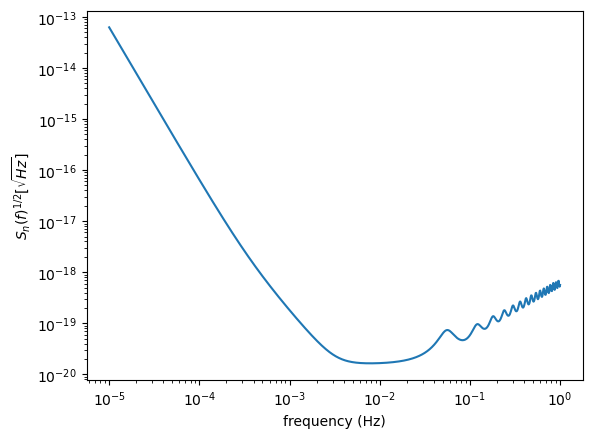

In [15]:
# log plot freq vs  sqrt of psd)
plt.figure()
plt.loglog(freq, np.sqrt(psd))

plt.ylabel(r"$S_n(f)^{ 1/2} [\sqrt {Hz} ]$")
plt.xlabel('frequency (Hz)')
plt.show()


In [16]:
wave_forSNR = few(M, mu, 9, e0, theta, phi, dt=dt, T=1/365) # generate the waveform
# take fourier transform of the waveform
wave_forSNR = np.fft.fft(wave_forSNR.real)
# same for the imaginary part
wave_forSNR_imag = np.fft.fft(wave_forSNR.imag)
# get the power spectrum
realval = np.abs(wave_forSNR)**2
# same for the imaginary part
imagval = np.abs(wave_forSNR_imag)**2

# add = power + power_imag and take a square root of the suma
addval= realval + imagval
sumval = np.sqrt(np.sum(addval))

In [17]:
# adding all the values in the power spectrum and taking a square root of the sum gives the SNR value.


print(sumval)
sumvalpsd = np.sqrt(sumpsd)
snr = sumval/sumvalpsd
print(snr)


49896.04074754956
2.053001128145932e+17


In [18]:


# # plot 
# plt.figure()
# plt.plot(cp.asnumpy(r_cp), cp.asnumpy(snr_cp), '.')
# plt.xlabel('r')
# plt.ylabel('SNR')
# plt.title('Signal-to-Noise Ratio (SNR) vs. Radial Coordinate (r)')
# plt.show()
# plt.show()
# plt.figure()
# plt.plot(np.array(cupy.array(r).get())  ,np.array(cupy.array(snr).get()), '.')
# plt.xlabel()
# plt.show()



    # plt.plot(cp.asnumpy(r.get()), cp.asnumpy(cp.stack(snrProfile).get()), '.')


In [19]:
import cupy as cp

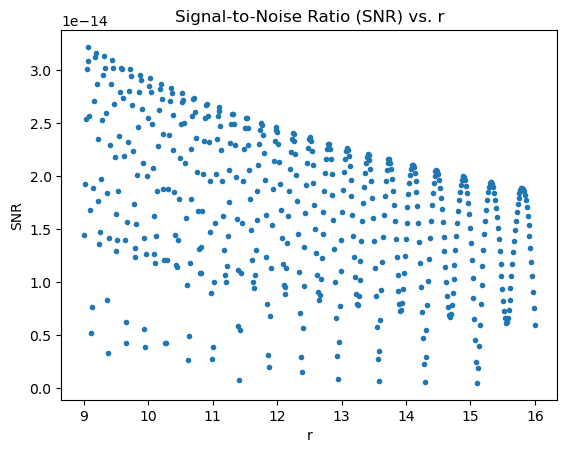

In [21]:
import numpy as np
import matplotlib.pyplot as plt


Msol=2e30
r = np.linspace(9, 16, 500)
sumvalr=[]
snr = []
for r_val in r:
    wave_forSNR = few(M, mu, r_val, e0, theta,phi,dist=dist1, dt=dt, T=1/365) # generate the waveform
    wave_forSNR = np.fft.fft(wave_forSNR.real) # take fourier transform of the waveform
    wave_forSNR_imag = np.fft.fft(wave_forSNR.imag) # same for the imaginary part
    realval = np.abs(wave_forSNR)**2 # get the power spectrum
    imagval = np.abs(wave_forSNR_imag)**2 # same for the imaginary part
    addval = realval + imagval # add = power + power_imag
    sumval = np.sqrt(np.sum(addval)) # take a square root of the sum
    sumvalr.append(sumval)
    snr.append(sumval/sumvalpsd) # store the snr value
# now in another loop print r an arrow and snr value
# i want to multiply my snr with solar mass and divide it by mu to get the snr in the right units. 

plt.figure()
plt.plot( np.array(cp.array(r).get())  ,np.array(cp.array(sumvalr).get()), '.')
# plt.plot( np.array(cupy.array(r).get())  ,np.array(cupy.array(snr).get()), '.')
plt.xlabel('r')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio (SNR) vs. r')
plt.show()


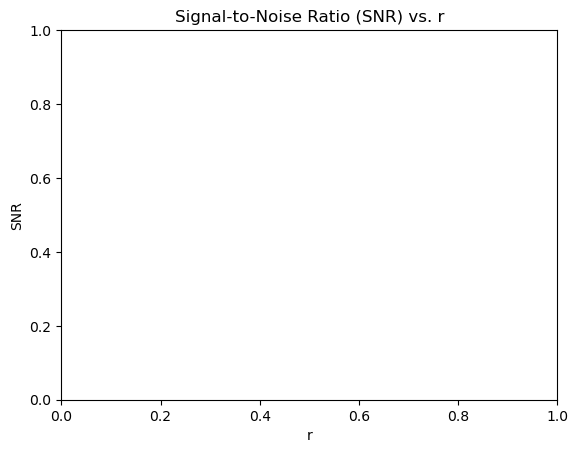

In [22]:
plt.figure()
# plt.plot( np.array(cupy.array(r).get())  ,np.array(cupy.array(sumvalr).get()), '.')
# plt.plot( np.array(cupy.array(r).get())  ,np.array(cupy.array(snr).get()), '.')
plt.xlabel('r')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio (SNR) vs. r')
plt.show()

In [31]:
def calculate_signalMod(r, L):
    wave = few(M, mu, r, e0, theta, phi, dist=dist1, dt=dt, T=L)
    fft_plus = cp.fft.fft(wave.real)
    fft_corss = cp.fft.fft(wave.imag)
    power_spectrum_real = cp.abs(fft_plus) ** 2
    power_spectrum_imag = cp.abs(fft_corss) ** 2
    power_spectrum = power_spectrum_real + power_spectrum_imag
    return power_spectrum
    
def calculate_snr(r_values, L):
    snr = []

    for r_val in r_values:
        signal_to = calculate_signalMod(r_val, 1/365)  # Assuming this is defined elsewhere
        freq = np.logspace(-5, 0, len(signal_to))
        psd = power_spectral_density_RCLfit(freq)  # Assuming this is defined elsewhere
        templ = []
        for i in range(len(psd)):
            ratio = signal_to[i] / psd[i]
            templ.append(ratio)
        templ = cp.array(templ)
        sum_temp = cp.sum(templ)
        snr.append(cp.sqrt(sum_temp).get())  # Retrieve result from GPU and append to list
    return snr


In [42]:
# # Iterate over different values of T
# # let l be an array of 9-16 with 20 values
# l= np.linspace(9, 16, 20)
# for L in [1 / 365]:
#     snrProfile = []
#     for p0 in r:
#         snrProfile.append(calculate_snr(l, L))


In [43]:
# rplt=np.array(cp.array(r).get())  
# snrplt=np.array(cp.array(snrProfile).get())
# plt.figure()
# plt.plot( rplt  ,snrplt/mu, '.')
# plt.xlabel('r')
# plt.title(f'SNR Profile for T = {L} years')
# plt.show()

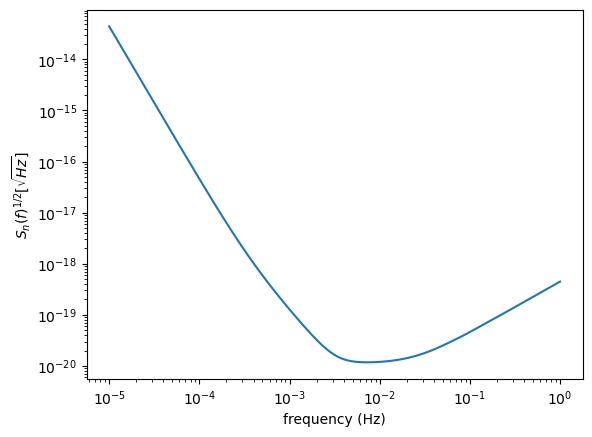

In [38]:
# a logsppace arrary frin -5 to 0 with 1000 points
freq = np.logspace(-5, 0, 1000)
power_spectral_density = power_spectral_density_RCLfit(freq)
plt.figure()
plt.loglog(freq, np.sqrt(power_spectral_density))
plt.xlabel('frequency (Hz)')
plt.ylabel(r'$S_n(f)^{1/2} [\sqrt{Hz}]$')
plt.show()


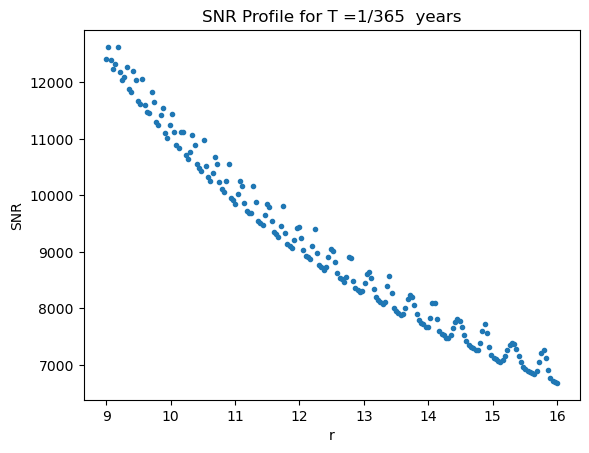

In [44]:
# store snr in a list
snr = []
r = np.linspace(9, 16, 200)

#make a loop to on r values
for r_val in range(len(r)): 
    signalto= calculate_signalMod(r[r_val], 1/365)
    freq=np.logspace(-5, 0, len(signalto))
    psd= power_spectral_density_RCLfit(freq)
    templ=[]
    sumtemp=0
    for i in range(len(psd)):
        ratio = signalto[i]/psd[i]
        templ.append(ratio)
    # convert the list to a cupy array
    templ = cp.array(templ)
    # sum the array

    sumtemp = np.sum(templ.get())

    snr.append(np.sqrt(sumtemp))





rplt=np.array(cp.array(r).get())  
snrplt=np.array(cp.array(snr).get())
plt.figure()
plt.plot( rplt  ,snrplt/mu, '.')
# plot a best fit line for the snr values

plt.xlabel('r')
plt.ylabel('SNR')
plt.title(f'SNR Profile for T =1/365  years')
plt.show()


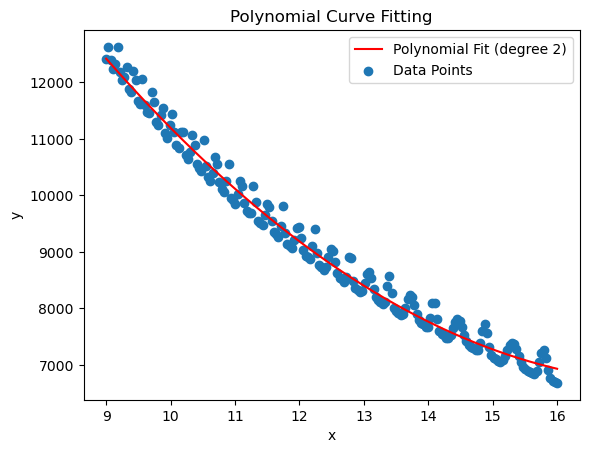

In [46]:
import numpy as np
x = rplt
y = snrplt/mu

degree = 2
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the fit
x_fit = np.linspace(min(x), max(x), 3000)
y_fit = polynomial(x_fit)

# Plot the original data points
plt.scatter(x, y, label='Data Points')

# Plot the fitted polynomial curve
plt.plot(x_fit, y_fit, label=f'Polynomial Fit (degree {degree})', color='red')

# Add labels and a legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Curve Fitting')
plt.legend()

# Show the plot
plt.show()
